# **🇯🇵 Kanji Handwritten Recognition - Training Notebook (PyTorch, Colab)**

# 1️⃣ MOUNT GOOGLE DRIVE & CÀI ĐẶT THƯ VIỆN


In [2]:
print("STEP 1: Mounting Google Drive and Installing Libraries...")
from google.colab import drive
import os
import subprocess

drive.mount('/content/drive')

# Cài đặt thư viện cần thiết
required_packages = [
    "torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu",
    "scikit-learn",
    "tqdm",
    "matplotlib",
    "seaborn",
    "japanize-matplotlib"
]
for package in required_packages:
    print(f"Installing {package.split()[0]}...")
    subprocess.run(f"pip install -q {package}", shell=True, check=True)

import japanize_matplotlib # Kích hoạt font tiếng Nhật cho matplotlib

print("\n✅ Libraries installed and Google Drive mounted successfully.")

STEP 1: Mounting Google Drive and Installing Libraries...
Mounted at /content/drive
Installing torch...
Installing scikit-learn...
Installing tqdm...
Installing matplotlib...
Installing seaborn...
Installing japanize-matplotlib...

✅ Libraries installed and Google Drive mounted successfully.


# 2️⃣ THIẾT LẬP CẤU HÌNH & ĐƯỜNG DẪN


In [3]:
print("\nSTEP 2: Setting up Configuration and Paths...")
import json
import random
import time
import glob
from pathlib import Path
import numpy as np
import torch

# --- Cấu hình chính ---
WORK_DIR = Path('/content/drive/MyDrive/kanji_handwritten_recognition')
DATASET_ROOT_CANDIDATES = [
    Path('/content/drive/MyDrive/kanji_handwritten_recognition/dataset/kkanji2'),
    Path('/content/kkanji2'), # Cho phép tải dataset lên thư mục gốc của Colab
]
MIN_IMAGES_PER_CLASS = 300 # Lọc các lớp có ít nhất 300 ảnh
IMG_SIZE = 96              # Giảm kích thước để tăng tốc độ trên CPU
BATCH_SIZE = 128
EPOCHS = 15                # Tăng số epoch một chút để mô hình có thêm thời gian học
LR = 3e-4                  # Giảm learning rate để huấn luyện ổn định hơn
WEIGHT_DECAY = 1e-5        # Giảm nhẹ weight decay
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
RANDOM_STATE = 42
NUM_WORKERS = 2            # Số core CPU sử dụng cho data loading
TOPK = 5                   # Dành cho Top-K accuracy
DEVICE = torch.device('cpu') # Chỉ định chạy trên CPU

# --- Thiết lập đường dẫn ---
(MODEL_DIR := WORK_DIR / 'models').mkdir(parents=True, exist_ok=True)
(PLOT_DIR  := WORK_DIR / 'plots').mkdir(parents=True, exist_ok=True)
(LOG_DIR   := WORK_DIR / 'logs').mkdir(parents=True, exist_ok=True)

# --- Tìm thư mục dataset ---
for cand in DATASET_ROOT_CANDIDATES:
    if cand.exists() and cand.is_dir():
        DATASET_DIR = cand
        break
else:
    raise FileNotFoundError(f"Dataset directory not found in any of the candidate paths: {DATASET_ROOT_CANDIDATES}")

print(f"Working Directory: {WORK_DIR}")
print(f"Dataset Directory: {DATASET_DIR}")
print(f"Device: {DEVICE}")

# --- Hàm tái tạo kết quả ---
def seed_all(seed: int = RANDOM_STATE) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # Không cần các hàm seed cho CUDA trên CPU

seed_all()
print("✅ Configuration complete.")


STEP 2: Setting up Configuration and Paths...
Working Directory: /content/drive/MyDrive/kanji_handwritten_recognition
Dataset Directory: /content/drive/MyDrive/kanji_handwritten_recognition/dataset/kkanji2
Device: cpu
✅ Configuration complete.


# 3️⃣ QUÉT DỮ LIỆU, LỌC LỚP & CHIA TẬP



STEP 3: Scanning Data, Filtering Classes, and Splitting Datasets...
Scanning 3832 folders...

Total classes found: 3832
Classes with >= 300 images: 93
Total images selected: 57130
  - Train set: 39990 images
  - Validation set: 8570 images
  - Test set: 8570 images


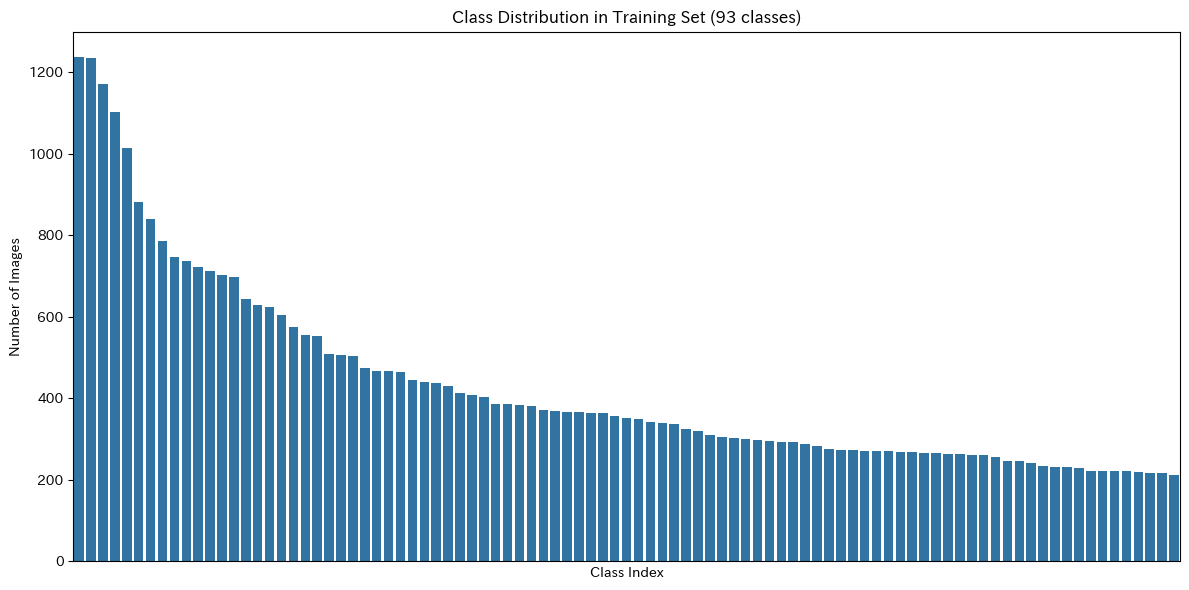

✅ Data preparation complete.


In [4]:
print("\nSTEP 3: Scanning Data, Filtering Classes, and Splitting Datasets...")
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

def folder_to_char(folder_name: str) -> str:
    """Chuyển tên thư mục dạng 'U+4E0A' thành ký tự '上'."""
    try:
        if folder_name.startswith('U+'):
            code_hex = folder_name[2:]
            return chr(int(code_hex, 16))
    except ValueError:
        pass
    return folder_name

# --- Quét và lọc các lớp đủ điều kiện ---
all_folders = sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir()])
class_counts = {}
print(f"Scanning {len(all_folders)} folders...")
for folder in all_folders:
    num_images = len(list((DATASET_DIR / folder).glob('*.png')))
    if num_images >= MIN_IMAGES_PER_CLASS:
        class_counts[folder] = num_images

selected_folders = sorted(class_counts.keys(), key=lambda k: class_counts[k], reverse=True)
if not selected_folders:
    raise ValueError(f"No classes found with at least {MIN_IMAGES_PER_CLASS} images.")

# --- Tạo các ánh xạ ---
idx2folder = {i: f for i, f in enumerate(selected_folders)}
folder2idx = {f: i for i, f in idx2folder.items()}
idx2char = {i: folder_to_char(f) for i, f in idx2folder.items()}
NUM_CLASSES = len(selected_folders)

# --- Lưu các ánh xạ ---
with open(WORK_DIR / 'idx2char.json', 'w', encoding='utf-8') as f:
    json.dump(idx2char, f, ensure_ascii=False, indent=2)

# --- Tạo danh sách ảnh và nhãn ---
image_paths, labels = [], []
for folder in selected_folders:
    paths = list((DATASET_DIR / folder).glob('*.png'))
    label_idx = folder2idx[folder]
    image_paths.extend(paths)
    labels.extend([label_idx] * len(paths))

# --- Chia train/val/test ---
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels,
    test_size=TEST_SPLIT, stratify=labels, random_state=RANDOM_STATE
)
relative_val_size = VAL_SPLIT / (1 - TEST_SPLIT)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=relative_val_size, stratify=y_temp, random_state=RANDOM_STATE
)

# --- Thống kê và trực quan hóa phân bố dữ liệu ---
print(f"\nTotal classes found: {len(all_folders)}")
print(f"Classes with >= {MIN_IMAGES_PER_CLASS} images: {NUM_CLASSES}")
print(f"Total images selected: {len(image_paths)}")
print(f"  - Train set: {len(X_train)} images")
print(f"  - Validation set: {len(X_val)} images")
print(f"  - Test set: {len(X_test)} images")

plt.figure(figsize=(12, 6))
sns.countplot(x=y_train, order=range(NUM_CLASSES))
plt.title(f'Class Distribution in Training Set ({NUM_CLASSES} classes)')
plt.xlabel('Class Index')
plt.ylabel('Number of Images')
plt.xticks([]) # Ẩn tick labels vì quá nhiều
plt.tight_layout()
plt.savefig(PLOT_DIR / 'class_distribution.png', dpi=150)
plt.show()

print("✅ Data preparation complete.")

# 4️⃣ TÍNH TOÁN CLASS WEIGHTS CHO HÀM LOSS


In [5]:
print("\nSTEP 4: Calculating Class Weights for Weighted Loss...")
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

print(f"Class weights calculated for {len(class_weights)} classes.")
print("✅ Weights are ready for the loss function.")


STEP 4: Calculating Class Weights for Weighted Loss...
Class weights calculated for 93 classes.
✅ Weights are ready for the loss function.


# 5️⃣ DATASET & DATALOADER


In [6]:
print("\nSTEP 5: Creating Datasets and DataLoaders...")
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# --- Định nghĩa các phép biến đổi ảnh (Augmentation) ---
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# --- Định nghĩa lớp Dataset ---
class KanjiDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('L') # Đảm bảo ảnh là grayscale
        return self.transform(image), label

# --- Tạo các DataLoader ---
train_dataset = KanjiDataset(X_train, y_train, train_transforms)
val_dataset = KanjiDataset(X_val, y_val, eval_transforms)
test_dataset = KanjiDataset(X_test, y_test, eval_transforms)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False,
    num_workers=NUM_WORKERS
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False,
    num_workers=NUM_WORKERS
)

print(f"DataLoaders created with batch size: {BATCH_SIZE} (train), {BATCH_SIZE*2} (eval).")
print("✅ DataLoaders are ready.")


STEP 5: Creating Datasets and DataLoaders...
DataLoaders created with batch size: 128 (train), 256 (eval).
✅ DataLoaders are ready.


# 6️⃣ ĐỊNH NGHĨA MÔ HÌNH RESNET18


In [7]:
print("\nSTEP 6: Defining the ResNet18 Model...")
import torch.nn as nn
import torchvision.models as models

def build_resnet18_grayscale(num_classes: int, dropout_rate: float = 0.5):
    # Tải mô hình ResNet18 không sử dụng trọng số đã huấn luyện trước
    model = models.resnet18(weights=None)

    # Chỉnh sửa lớp Conv đầu tiên để chấp nhận đầu vào 1 kênh (ảnh xám)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Thay thế lớp phân loại cuối cùng bằng một Sequential block mới
    # bao gồm Dropout để chống overfitting
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(num_features, num_classes)
    )
    return model

model = build_resnet18_grayscale(num_classes=NUM_CLASSES).to(DEVICE)
print(model)
print("✅ ResNet18 model created successfully.")


STEP 6: Defining the ResNet18 Model...
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

# 7️⃣ THIẾT LẬP VÒNG LẶP HUẤN LUYỆN


In [8]:
print("\nSTEP 7: Setting up the Training Loop...")
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# --- Hàm Loss, Optimizer và Scheduler ---
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

# --- Lớp EarlyStopping ---
class EarlyStopping:
    def __init__(self, patience: int = 5, delta: float = 1e-4, mode: str = 'max', path: str = 'best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.path = path
        self.best_score = -float('inf') if mode == 'max' else float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, score: float, model: nn.Module):
        is_better = (score > self.best_score + self.delta) if self.mode == 'max' else (score < self.best_score - self.delta)
        if is_better:
            self.best_score = score
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            print(f"✨ New best model saved with score: {self.best_score:.4f}")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=5, path=str(MODEL_DIR / 'best_model.pth'))

print("✅ Training components are ready.")


STEP 7: Setting up the Training Loop...
✅ Training components are ready.


# 8️⃣ QUÁ TRÌNH HUẤN LUYỆN


In [9]:
print("\nSTEP 8: Starting the Training Process...")

def evaluate(loader, model, criterion):
    model.eval()
    total_loss = 0.0
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_loss = total_loss / len(loader)
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, accuracy, f1_macro, all_labels, all_preds, all_probs

start_time = time.time()
history = {
    'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'lr': []
}

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)

    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    # --- End of epoch ---
    train_loss = running_loss / len(train_loader)
    val_loss, val_acc, val_f1, _, _, _ = evaluate(val_loader, model, criterion)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['lr'].append(optimizer.param_groups[0]['lr'])

    scheduler.step(val_loss)

    print(f"[{epoch:02d}/{EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    early_stopper(val_f1, model)
    if early_stopper.early_stop:
        print("Early stopping triggered. Halting training.")
        break

# --- Final actions ---
torch.save(model.state_dict(), MODEL_DIR / 'last_model.pth')
with open(LOG_DIR / 'metrics_history.json', 'w') as f:
    json.dump(history, f, indent=2)

total_time = time.time() - start_time
print(f"\n✅ Training finished in {total_time/60:.2f} minutes.")
print(f"Best model saved at: {MODEL_DIR / 'best_model.pth'}")
print(f"Last model saved at: {MODEL_DIR / 'last_model.pth'}")


STEP 8: Starting the Training Process...


[01/15] Train Loss: 2.0870 | Val Loss: 0.4735 | Val Acc: 0.8728 | Val F1: 0.8594
✨ New best model saved with score: 0.8594


[02/15] Train Loss: 0.4701 | Val Loss: 0.3030 | Val Acc: 0.9215 | Val F1: 0.9138
✨ New best model saved with score: 0.9138


[03/15] Train Loss: 0.2775 | Val Loss: 0.1481 | Val Acc: 0.9604 | Val F1: 0.9565
✨ New best model saved with score: 0.9565


[04/15] Train Loss: 0.2123 | Val Loss: 0.1179 | Val Acc: 0.9713 | Val F1: 0.9673
✨ New best model saved with score: 0.9673


[05/15] Train Loss: 0.1645 | Val Loss: 0.1410 | Val Acc: 0.9644 | Val F1: 0.9590


[06/15] Train Loss: 0.1401 | Val Loss: 0.1144 | Val Acc: 0.9707 | Val F1: 0.9674


[07/15] Train Loss: 0.1172 | Val Loss: 0.1108 | Val Acc: 0.9711 | Val F1: 0.9678
✨ New best model saved with score: 0.9678


[08/15] Train Loss: 0.1048 | Val Loss: 0.0905 | Val Acc: 0.9775 | Val F1: 0.9745
✨ New best model saved with score: 0.9745


[09/15] Train Loss: 0.1073 | Val Loss: 0.0753 | Val Acc: 0.9800 | Val F1: 0.9786
✨ New best model saved with score: 0.9786


[10/15] Train Loss: 0.0897 | Val Loss: 0.0752 | Val Acc: 0.9785 | Val F1: 0.9768


[11/15] Train Loss: 0.0833 | Val Loss: 0.0842 | Val Acc: 0.9790 | Val F1: 0.9769


[12/15] Train Loss: 0.0794 | Val Loss: 0.0671 | Val Acc: 0.9832 | Val F1: 0.9821
✨ New best model saved with score: 0.9821


[13/15] Train Loss: 0.0702 | Val Loss: 0.0863 | Val Acc: 0.9792 | Val F1: 0.9771


[14/15] Train Loss: 0.0679 | Val Loss: 0.1001 | Val Acc: 0.9763 | Val F1: 0.9736


[15/15] Train Loss: 0.0656 | Val Loss: 0.1076 | Val Acc: 0.9741 | Val F1: 0.9717

✅ Training finished in 673.88 minutes.
Best model saved at: /content/drive/MyDrive/kanji_handwritten_recognition/models/best_model.pth
Last model saved at: /content/drive/MyDrive/kanji_handwritten_recognition/models/last_model.pth


# 9️⃣ ĐÁNH GIÁ TRÊN TẬP TEST VÀ BÁO CÁO


In [10]:
print("\nSTEP 9: Evaluating on Test Set and Generating Reports...")
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Tải mô hình tốt nhất để đánh giá
best_model = build_resnet18_grayscale(num_classes=NUM_CLASSES).to(DEVICE)
best_model.load_state_dict(torch.load(MODEL_DIR / 'best_model.pth', map_location=DEVICE))

test_loss, test_acc, test_f1, y_true, y_pred, y_prob = evaluate(test_loader, best_model, criterion)

print("\n--- Test Set Performance ---")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score (Macro): {test_f1:.4f}")

# --- Classification Report ---
report_dict = classification_report(
    y_true, y_pred,
    labels=list(idx2char.keys()),
    target_names=[idx2char[i] for i in idx2char.keys()],
    output_dict=True,
    zero_division=0
)
with open(LOG_DIR / 'classification_report.json', 'w', encoding='utf-8') as f:
    json.dump(report_dict, f, ensure_ascii=False, indent=2)
print(f"\nClassification report saved to: {LOG_DIR / 'classification_report.json'}")

# --- Top-K Accuracy ---
def topk_accuracy(y_true, y_prob, k: int = 5):
    topk_preds = np.argsort(-y_prob, axis=1)[:, :k]
    matches = np.any(topk_preds == np.array(y_true)[:, None], axis=1)
    return np.mean(matches)

top5_acc = topk_accuracy(y_true, y_prob, k=TOPK)
print(f"Top-{TOPK} Accuracy: {top5_acc:.4f}")

print("\n✅ Evaluation complete.")


STEP 9: Evaluating on Test Set and Generating Reports...

--- Test Set Performance ---
Loss: 0.0672
Accuracy: 0.9827
F1 Score (Macro): 0.9807

Classification report saved to: /content/drive/MyDrive/kanji_handwritten_recognition/logs/classification_report.json
Top-5 Accuracy: 0.9968

✅ Evaluation complete.


# 1️⃣0️⃣ VẼ BIỂU ĐỒ KẾT QUẢ



STEP 10: Plotting Results...


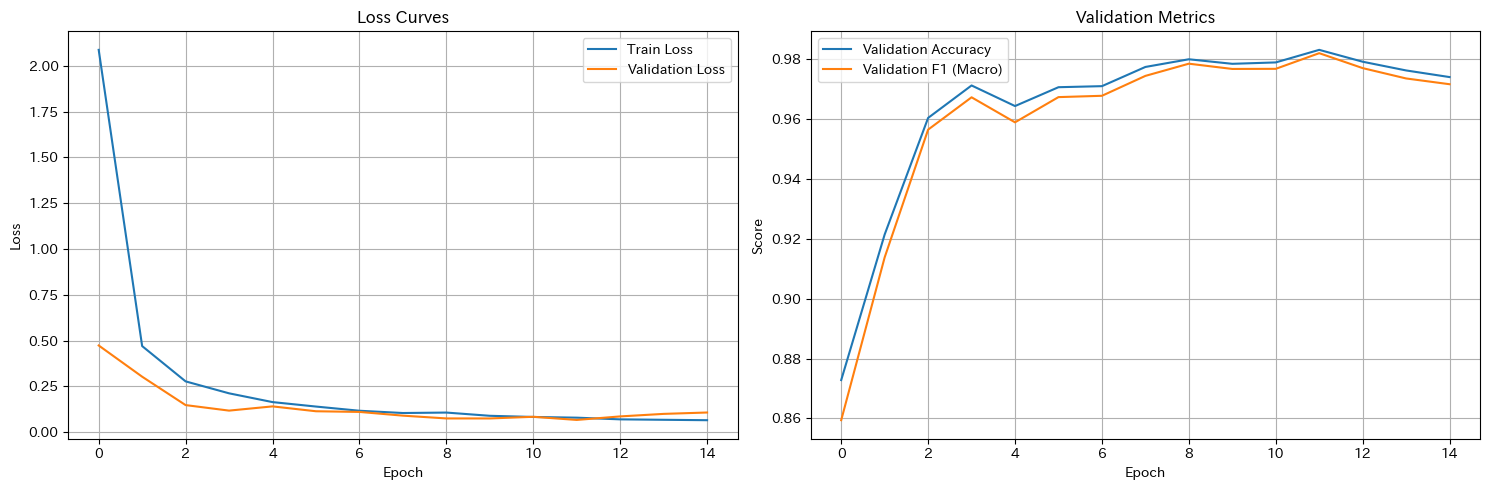

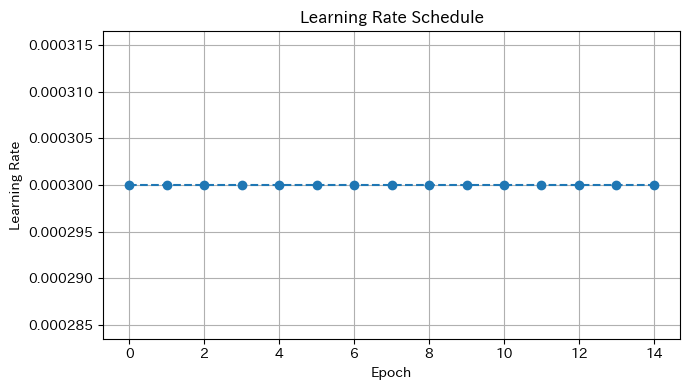

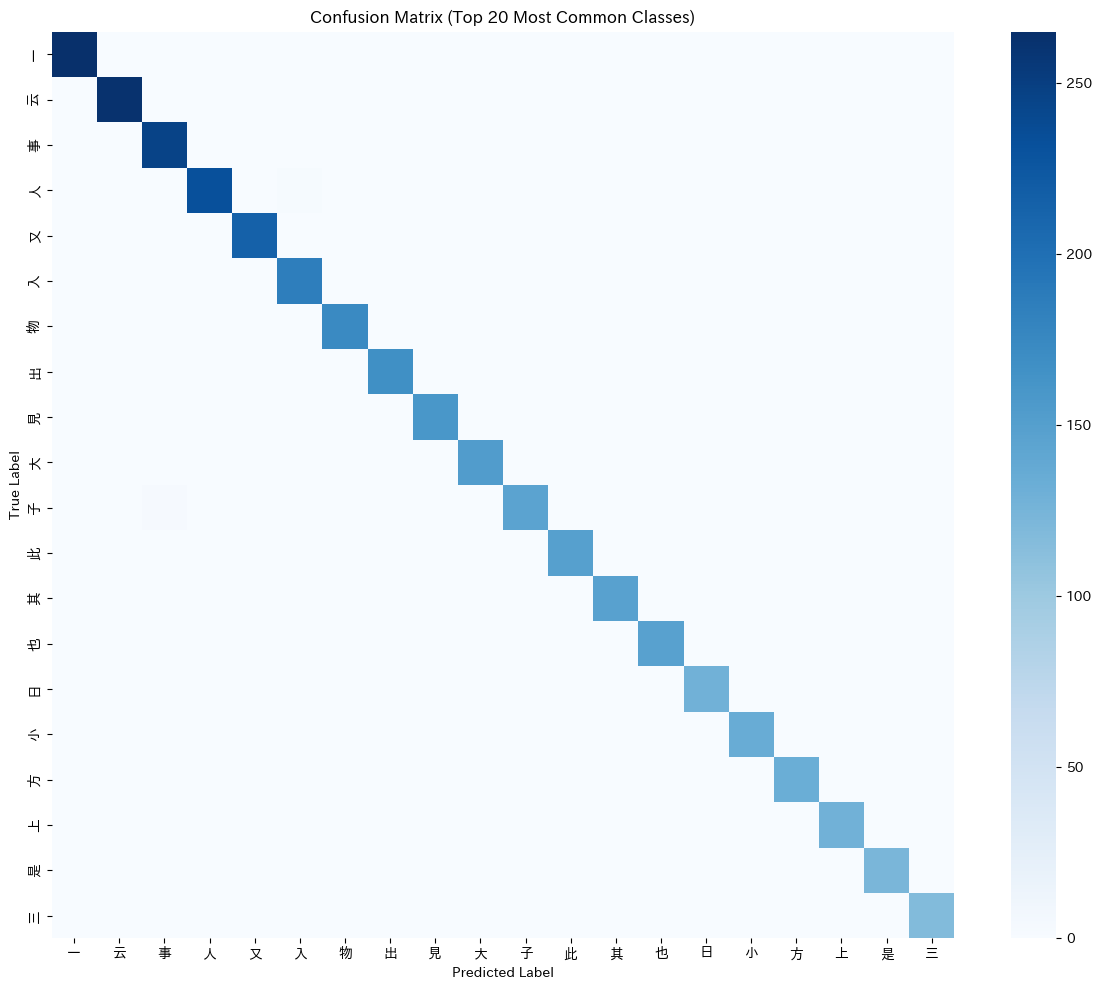

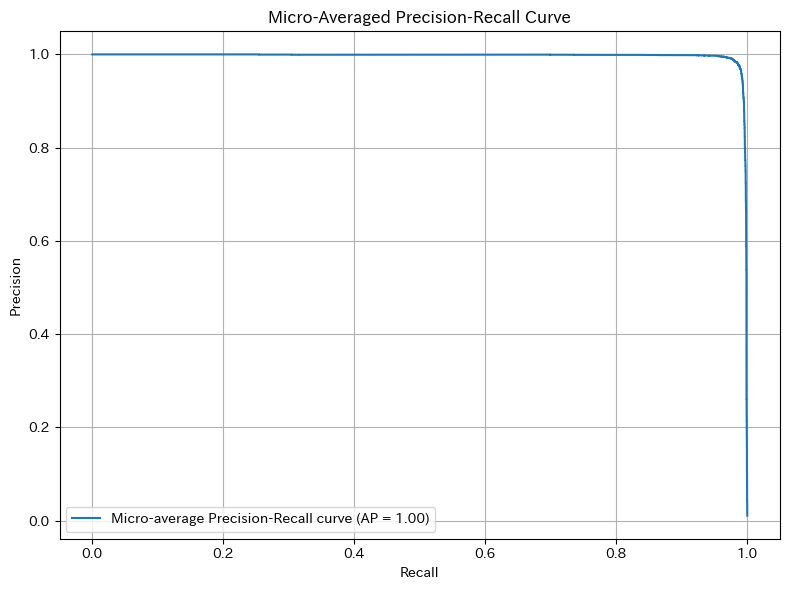

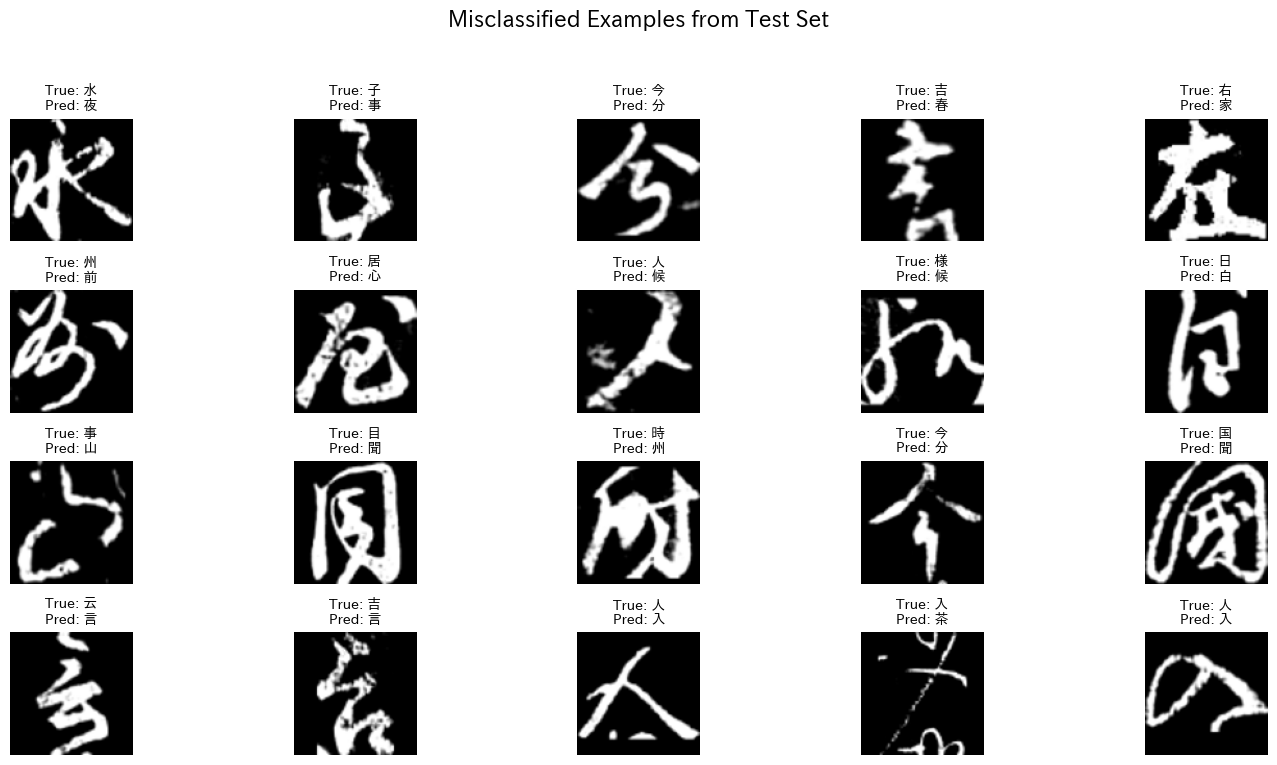

✅ All plots have been generated and saved.


In [11]:
print("\nSTEP 10: Plotting Results...")
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
from itertools import cycle

# --- Biểu đồ Loss và Metrics ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.legend(); ax1.grid(True)

ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.plot(history['val_f1'], label='Validation F1 (Macro)')
ax2.set_title('Validation Metrics')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Score')
ax2.legend(); ax2.grid(True)

plt.tight_layout()
plt.savefig(PLOT_DIR / 'loss_and_metrics_curves.png', dpi=150)
plt.show()

# --- Biểu đồ Learning Rate ---
plt.figure(figsize=(7, 4))
plt.plot(history['lr'], marker='o', linestyle='--')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch'); plt.ylabel('Learning Rate')
plt.grid(True)
plt.tight_layout()
plt.savefig(PLOT_DIR / 'learning_rate_schedule.png', dpi=150)
plt.show()

# --- Confusion Matrix (Top 20 lớp) ---
support_counter = Counter(y_true)
TOP_N_CM = 20
top_classes_indices = [c for c, _ in support_counter.most_common(TOP_N_CM)]

mask = np.isin(y_true, top_classes_indices)
cm = confusion_matrix(np.array(y_true)[mask], np.array(y_pred)[mask], labels=top_classes_indices)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=[idx2char[i] for i in top_classes_indices],
            yticklabels=[idx2char[i] for i in top_classes_indices])
plt.title(f'Confusion Matrix (Top {TOP_N_CM} Most Common Classes)')
plt.xlabel('Predicted Label'); plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(PLOT_DIR / 'confusion_matrix.png', dpi=200)
plt.show()

# --- Precision-Recall Curve ---
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
precision, recall, average_precision = {}, {}, {}

# Micro-average
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_prob.ravel())
average_precision["micro"] = average_precision_score(y_true_bin, y_prob, average="micro")

plt.figure(figsize=(8, 6))
plt.step(recall['micro'], precision['micro'], where='post',
         label=f'Micro-average Precision-Recall curve (AP = {average_precision["micro"]:.2f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Micro-Averaged Precision-Recall Curve')
plt.legend(loc="lower left"); plt.grid(True);
plt.tight_layout()
plt.savefig(PLOT_DIR / 'precision_recall_curve.png', dpi=150)
plt.show()


# --- Ví dụ dự đoán sai ---
misclassified_indices = np.where(np.array(y_pred) != np.array(y_true))[0]
if len(misclassified_indices) > 0:
    sample_indices = np.random.choice(misclassified_indices, size=min(20, len(misclassified_indices)), replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(sample_indices):
        img_path = test_dataset.paths[idx]
        true_label = idx2char[test_dataset.labels[idx]]
        pred_label = idx2char[y_pred[idx]]

        img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
        plt.subplot(4, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        plt.axis('off')
    plt.suptitle('Misclassified Examples from Test Set', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(PLOT_DIR / 'misclassified_examples.png', dpi=200)
    plt.show()

print("✅ All plots have been generated and saved.")

# 1️⃣1️⃣ LƯU ARTIFACTS


In [12]:
print("\nSTEP 11: Saving Final Artifacts Manifest...")

artifacts = {
    'model_config': {
        'IMG_SIZE': IMG_SIZE,
        'NUM_CLASSES': NUM_CLASSES,
        'MIN_IMAGES_PER_CLASS': MIN_IMAGES_PER_CLASS,
    },
    'training_config': {
        'EPOCHS': EPOCHS,
        'BATCH_SIZE': BATCH_SIZE,
        'LEARNING_RATE': LR,
    },
    'paths': {
        'best_model': str(MODEL_DIR / 'best_model.pth'),
        'last_model': str(MODEL_DIR / 'last_model.pth'),
        'idx2char_map': str(WORK_DIR / 'idx2char.json'),
        'metrics_history': str(LOG_DIR / 'metrics_history.json'),
        'classification_report': str(LOG_DIR / 'classification_report.json'),
        'plots': [str(p) for p in PLOT_DIR.glob('*.png')]
    }
}

with open(WORK_DIR / 'artifacts.json', 'w', encoding='utf-8') as f:
    json.dump(artifacts, f, indent=4, ensure_ascii=False)

print(f"✅ Artifacts manifest saved to: {WORK_DIR / 'artifacts.json'}")
print("\n🎉 PIPELINE COMPLETED SUCCESSFULLY! 🎉")


STEP 11: Saving Final Artifacts Manifest...
✅ Artifacts manifest saved to: /content/drive/MyDrive/kanji_handwritten_recognition/artifacts.json

🎉 PIPELINE COMPLETED SUCCESSFULLY! 🎉
